In [80]:
# --- Paths (edit if needed) ---
from pathlib import Path

# BLAST results + sequences
PATH_HITS   = Path("../external_results_tools/4J6C457P013-Alignment-HitTable.csv")
PATH_SEQDMP = Path("../external_results_tools/seqdump.txt")     # subject sequences
PATH_TRANS  = Path("../external_results_tools/translate.txt")   # translated frames (A. purpuratus)

# Work and outputs
DIR_TMP     = Path("../tmp");           DIR_TMP.mkdir(exist_ok=True, parents=True)
DIR_FIG     = Path("../figures_paper"); DIR_FIG.mkdir(exist_ok=True, parents=True)

FA_F2       = DIR_TMP / "frame2.fasta"
FA_F3       = DIR_TMP / "frame3.fasta"
ALN_F2      = DIR_TMP / "aligned_frame2.fasta"
ALN_F3      = DIR_TMP / "aligned_frame3.fasta"

OUT_FIG     = DIR_FIG / "phylo_QC_and_trees.png"
OUT_PDF     = DIR_FIG / "phylo_QC_and_trees.pdf"

print("Using:", PATH_HITS.resolve())
print("TMP:", DIR_TMP.resolve())
print("FIG:", OUT_FIG.resolve())

Using: /home/david/Desktop/colabs/maya_gianina_colabs/PI5P4K_analysis/external_results_tools/4J6C457P013-Alignment-HitTable.csv
TMP: /home/david/Desktop/colabs/maya_gianina_colabs/PI5P4K_analysis/tmp
FIG: /home/david/Desktop/colabs/maya_gianina_colabs/PI5P4K_analysis/figures_paper/phylo_QC_and_trees.png


In [81]:
# --- Imports ---
import re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from Bio import SeqIO, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", context="notebook", font_scale=1.1)

In [82]:
def select_by_gmm(df_frame, pmin=0.90, emax=1e-5):
    df = df_frame.copy()
    # Features: Identity, Coverage, -log10(E)
    ev = df["E-value"].clip(lower=np.finfo(float).tiny)  # evitar log(0)
    X = pd.DataFrame({
        "id": df["Identity"].astype(float),
        "cov": df["Coverage"].astype(float),
        "logE": -np.log10(ev.astype(float))
    })
    # Escalado
    Z = StandardScaler().fit_transform(X)

    gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=0)
    gmm.fit(Z)
    proba = gmm.predict_proba(Z)
    labels = gmm.predict(Z)

    # elegir el componente con mayor media de identidad+cov (el "bueno")
    means = gmm.means_
    idx_good = np.argmax(means[:,0] + means[:,1])

    keep = (labels == idx_good) & (proba[:, idx_good] >= pmin)
    df_sel = df.loc[keep].copy()

    # “umbrales equivalentes” (mínimo dentro del clúster bueno)
    thr_id  = df_sel["Identity"].min()
    thr_cov = df_sel["Coverage"].min()
    thr_logE = (-np.log10(df_sel["E-value"].clip(lower=np.finfo(float).tiny))).min()

    return df_sel, {"Identity_min": thr_id, "Coverage_min": thr_cov, "-log10(E)_min": thr_logE,
                    "n_selected": len(df_sel), "n_total": len(df)}

In [83]:
def _safe_num(s):
    return pd.to_numeric(s, errors="coerce")

def _frame_metrics(df_frame: pd.DataFrame) -> dict:
    """Calcula métricas clave para un frame."""
    if df_frame is None or len(df_frame) == 0:
        return dict(n=0, id_med=np.nan, cov_med=np.nan, logE_med=np.nan,
                    id_p90=np.nan, cov_p90=np.nan, logE_p90=np.nan)

    d = df_frame.copy()
    d["Identity"] = _safe_num(d["Identity"])
    d["Coverage"] = _safe_num(d["Coverage"])
    ev = _safe_num(d["E-value"]).clip(lower=np.finfo(float).tiny)
    logE = -np.log10(ev)

    return dict(
        n       = int(len(d)),
        id_med  = float(np.nanmedian(d["Identity"])),
        cov_med = float(np.nanmedian(d["Coverage"])),
        logE_med= float(np.nanmedian(logE)),
        id_p90  = float(np.nanpercentile(d["Identity"], 90)),
        cov_p90 = float(np.nanpercentile(d["Coverage"], 90)),
        logE_p90= float(np.nanpercentile(logE, 90)),
    )

def _minmax_norm(a):
    a = np.asarray(a, dtype=float)
    if np.all(np.isnan(a)):  # todo NaN
        return np.zeros_like(a)
    amin = np.nanmin(a); amax = np.nanmax(a)
    if not np.isfinite(amin) or not np.isfinite(amax) or amax - amin == 0:
        # si no hay variación, todos a 0.5
        return np.full_like(a, 0.5)
    return (a - amin) / (amax - amin)

def choose_best_frame(df_f2: pd.DataFrame, df_f3: pd.DataFrame, weights=None, verbose=True):
    """
    Devuelve (best_frame, diagnostics_df).
    weights: dict con pesos del score (puedes ajustarlos).
    """
    if weights is None:
        weights = dict(id_med=0.35, cov_med=0.35, logE_med=0.20, id_p90=0.05, cov_p90=0.05, n=0.0)
        # Nota: puedes subir 'n' a 0.1 si quieres premiar soporte

    by_frame = { -2: _frame_metrics(df_f2), -3: _frame_metrics(df_f3) }
    diag = pd.DataFrame(by_frame).T  # filas = frames
    # normalizar cada métrica por min–max entre frames (solo dos, muy estable)
    for k in ["id_med","cov_med","logE_med","id_p90","cov_p90","n"]:
        diag[k+"_norm"] = _minmax_norm(diag[k].values)

    # score compuesto
    score = np.zeros(len(diag))
    for k, w in weights.items():
        score += w * diag[k+"_norm"].values
    diag["score"] = score

    # elegir frame con mayor score (si empate, el de mayor 'id_med_norm')
    best_idx = np.argmax(diag["score"].values)
    best_frame = diag.index[best_idx]

    if verbose:
        print("Diagnostics per frame:")
        display(diag.round(3))

    return int(best_frame), diag


In [84]:
def pick_representatives(df_hits, per_species=1, k_max=40):
    d = df_hits.copy()
    d["score"] = _safe_num(d["Identity"]) * _safe_num(d["Coverage"])
    # asume que ya tienes una columna 'Organism' (como en tu pipeline)
    reps = (d.sort_values(["Organism","score"], ascending=[True, False])
              .groupby("Organism", as_index=False).head(per_species))
    reps = reps.sort_values("score", ascending=False).head(k_max)
    return reps

In [85]:
# --- Helper functions ---
from unicodedata import normalize

def norm_text(s:str)->str:
    return normalize("NFKC", str(s)).replace("’","'").strip()

def get_subtype(description: str) -> str:
    d = (description or "").upper()
    return "Alpha" if "ALPHA" in d else "NA"

def get_organism(description: str) -> str:
    try:
        org = description.split("[")[1].split("]")[0].strip().replace(" ", "-")
    except Exception:
        org = "NA"
    return org

def check_entries_to_ignore(description: str) -> bool:
    d = (description or "").lower()
    bad = ["hypothetical","unnamed","uncharacterized","putative","partial",
           "low quality","fragment","pseudogene"]
    return any(b in d for b in bad)

def prepare_sequences_for_MSA(dataset: pd.DataFrame, sequence_input: str, id_seq: str, name_export: Path):
    records = []
    for _, row in dataset.iterrows():
        sequence = row["sequence"]
        acc = row["Accession"]
        parts = (row.get("Organism","NA") or "NA-NA").split("-")
        organism = f"{parts[0][0]}.-{parts[1]}" if len(parts)>1 and parts[0] else parts[0]
        subtype = row.get("Subtype","NA")
        rec_id  = f"[{acc}]-{organism}|{subtype}"
        records.append(SeqRecord(Seq(sequence), id=rec_id, description=""))
    records.append(SeqRecord(Seq(sequence_input), id=id_seq, description=""))
    SeqIO.write(records, name_export, "fasta")

def run_msa(aligned_file: Path, fasta_file: Path):
    cl = ClustalOmegaCommandline(infile=str(fasta_file), outfile=str(aligned_file),
                                 verbose=True, auto=True, force=True)
    print(f"Running MSA -> {aligned_file}")
    stdout, stderr = cl()

def build_tree_from_alignment(aligned_file: Path):
    alignment = AlignIO.read(str(aligned_file), "fasta")
    calculator = DistanceCalculator("blosum62")
    constructor = DistanceTreeConstructor()
    dm = calculator.get_distance(alignment)
    return constructor.nj(dm)

def draw_tree_ax(tree, ax, title:str):
    # color only the A. purpuratus query in green; others dark grey
    label_colors = {}
    for clade in tree.find_clades():
        if clade.name and not clade.is_terminal() and clade.name.lower().startswith("inner"):
            clade.name = None
            
        if clade.name and ("A.purpuratus" in clade.name):
            label_colors[clade.name] = "#136f63"
        elif clade.name:
            label_colors[clade.name] = "#222222"
    Phylo.draw(tree, do_show=False, axes=ax, label_colors=label_colors, show_confidence=False)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Branch length")
    ax.set_ylabel("Taxa")


def add_panel_letter(fig, ax, letter, pad_y=0.006):
    bb = ax.get_position()
    fig.text(bb.x0-0.05, bb.y1 + pad_y, letter,
             fontsize=14, fontweight="bold", ha="left", va="bottom")

In [86]:
# --- Read BLAST hits and Alpha-filter ---
hits = pd.read_csv(PATH_HITS, header=None)
hits.columns = ["query","Accession","Identity","Coverage","Mismatches","Gaps",
                "Q_Start","Q_End","S_Start","S_End","E-value","Max-Score","-","Frame","--"]
hits = hits.drop(columns=["query","Mismatches","Gaps","Max-Score","-","Q_Start","Q_End","S_Start","S_End","--"])

seqdump = []
for rec in SeqIO.parse(str(PATH_SEQDMP), "fasta"):
    seqdump.append({"id_sequence": rec.id, "sequence": str(rec.seq), "description": rec.description})
fasta_df = pd.DataFrame(seqdump)

df = hits.merge(fasta_df, left_on="Accession", right_on="id_sequence", how="left")
df["to_ignore"] = df["description"].apply(check_entries_to_ignore)
df = df[df["to_ignore"]==False].copy()
df["Organism"] = df["description"].apply(get_organism)
df["Subtype"]  = df["description"].apply(get_subtype)

# Keep Alpha only
df = df[df["Subtype"]=="Alpha"].copy()

# Split by frame (-2, -3)
df_f2 = df[df["Frame"]==-2].copy()
df_f3 = df[df["Frame"]==-3].copy()

print("Alpha-only counts -> Frame -2:", df_f2.shape[0], " | Frame -3:", df_f3.shape[0])

Alpha-only counts -> Frame -2: 64  | Frame -3: 64


In [87]:
f3_1, thr3 = select_by_gmm(df_f3)   # frame -3
f2_1, thr2 = select_by_gmm(df_f2)   # frame -2

print("Frame -3 (GMM):", thr3)
print("Frame -2 (GMM):", thr2)

Frame -3 (GMM): {'Identity_min': np.float64(64.286), 'Coverage_min': np.int64(54), '-log10(E)_min': np.float64(44.04143611677803), 'n_selected': 36, 'n_total': 64}
Frame -2 (GMM): {'Identity_min': np.float64(62.5), 'Coverage_min': np.int64(88), '-log10(E)_min': np.float64(44.04143611677803), 'n_selected': 43, 'n_total': 64}


In [88]:
# --- Apply numeric thresholds (same as before) ---
f3 = df_f3[(df_f3["Identity"] >= thr3['Identity_min']) & (df_f3["Coverage"] >= thr3['Coverage_min'])].copy()
f2 = df_f2[(df_f2["Identity"] >= thr2['Identity_min']) & (df_f2["Coverage"] >= thr2['Identity_min'])].copy()
print("Selected (Alpha) — Frame -3:", f3.shape, " | Frame -2:", f2.shape)

Selected (Alpha) — Frame -3: (36, 11)  | Frame -2: (64, 11)


In [89]:
best_frame, diag = choose_best_frame(df_f2, df_f3)
print("Best frame =", best_frame)

Diagnostics per frame:


,n,id_med,cov_med,logE_med,id_p90,cov_p90,logE_p90,id_med_norm,cov_med_norm,logE_med_norm,id_p90_norm,cov_p90_norm,n_norm,score
-2,64.0,70.455,88.0,47.382,82.759,88.0,55.795,0.0,1.0,0.5,1.0,1.0,0.5,0.55
-3,64.0,73.111,54.0,47.382,81.400,54.0,55.795,1.0,0.0,0.5,0.0,0.0,0.5,0.45


Best frame = -2


In [90]:
if best_frame == -2:
    f_use = pick_representatives(df_f2, per_species=1, k_max=25)
else:
    f_use = pick_representatives(df_f3, per_species=1, k_max=25)
print("Representatives:", f_use.shape)

Representatives: (25, 12)


In [91]:
# --- Robustly pick A. purpuratus sequences for Frame 2 and Frame 3 ---
translated = []
for rec in SeqIO.parse(str(PATH_TRANS), "fasta"):
    translated.append({"id_sequence": norm_text(rec.id), "sequence": str(rec.seq), "description": norm_text(rec.description)})
df_translate = pd.DataFrame(translated)
df_translate["frame_num"] = (
    df_translate["description"].str.extract(r"Frame\s*([-+]?\d+)", expand=False).astype("Int64")
)
cand = df_translate[df_translate["id_sequence"].isin(["3'5'","5'3'"])].copy()
cand = cand[cand["frame_num"] != 1]

def get_seq_for_frame(cand_df: pd.DataFrame, frame: int) -> str:
    sub = cand_df[(cand_df["id_sequence"]=="3'5'") & (cand_df["frame_num"]==frame)]
    if len(sub): return sub.iloc[0]["sequence"]
    sub = cand_df[(cand_df["id_sequence"]=="5'3'") & (cand_df["frame_num"]==frame)]
    if len(sub): return sub.iloc[0]["sequence"]
    sub = cand_df[(cand_df["frame_num"]==frame)]
    if len(sub): return sub.iloc[0]["sequence"]
    raise ValueError(f"No se encontró secuencia para Frame {frame}. Disponibles:\n{cand_df[['id_sequence','description','frame_num']]}")

seq_frame2 = get_seq_for_frame(cand, 2)
seq_frame3 = get_seq_for_frame(cand, 3)

# Write Alpha-only FASTA sets for each frame (subject hits + query)
prepare_sequences_for_MSA(f2, seq_frame2, "A.purpuratus", FA_F2)
prepare_sequences_for_MSA(f3, seq_frame3, "A.purpuratus", FA_F3)
print("FASTA written:", FA_F2, FA_F3)

FASTA written: ../tmp/frame2.fasta ../tmp/frame3.fasta


In [92]:
# --- Run MSA if aligned files are missing ---
run_msa(ALN_F2, FA_F2)
run_msa(ALN_F3, FA_F3)

Running MSA -> ../tmp/aligned_frame2.fasta


Running MSA -> ../tmp/aligned_frame3.fasta


In [93]:
# --- Build NJ trees from alignments ---
tree_f2 = build_tree_from_alignment(ALN_F2)
tree_f3 = build_tree_from_alignment(ALN_F3)

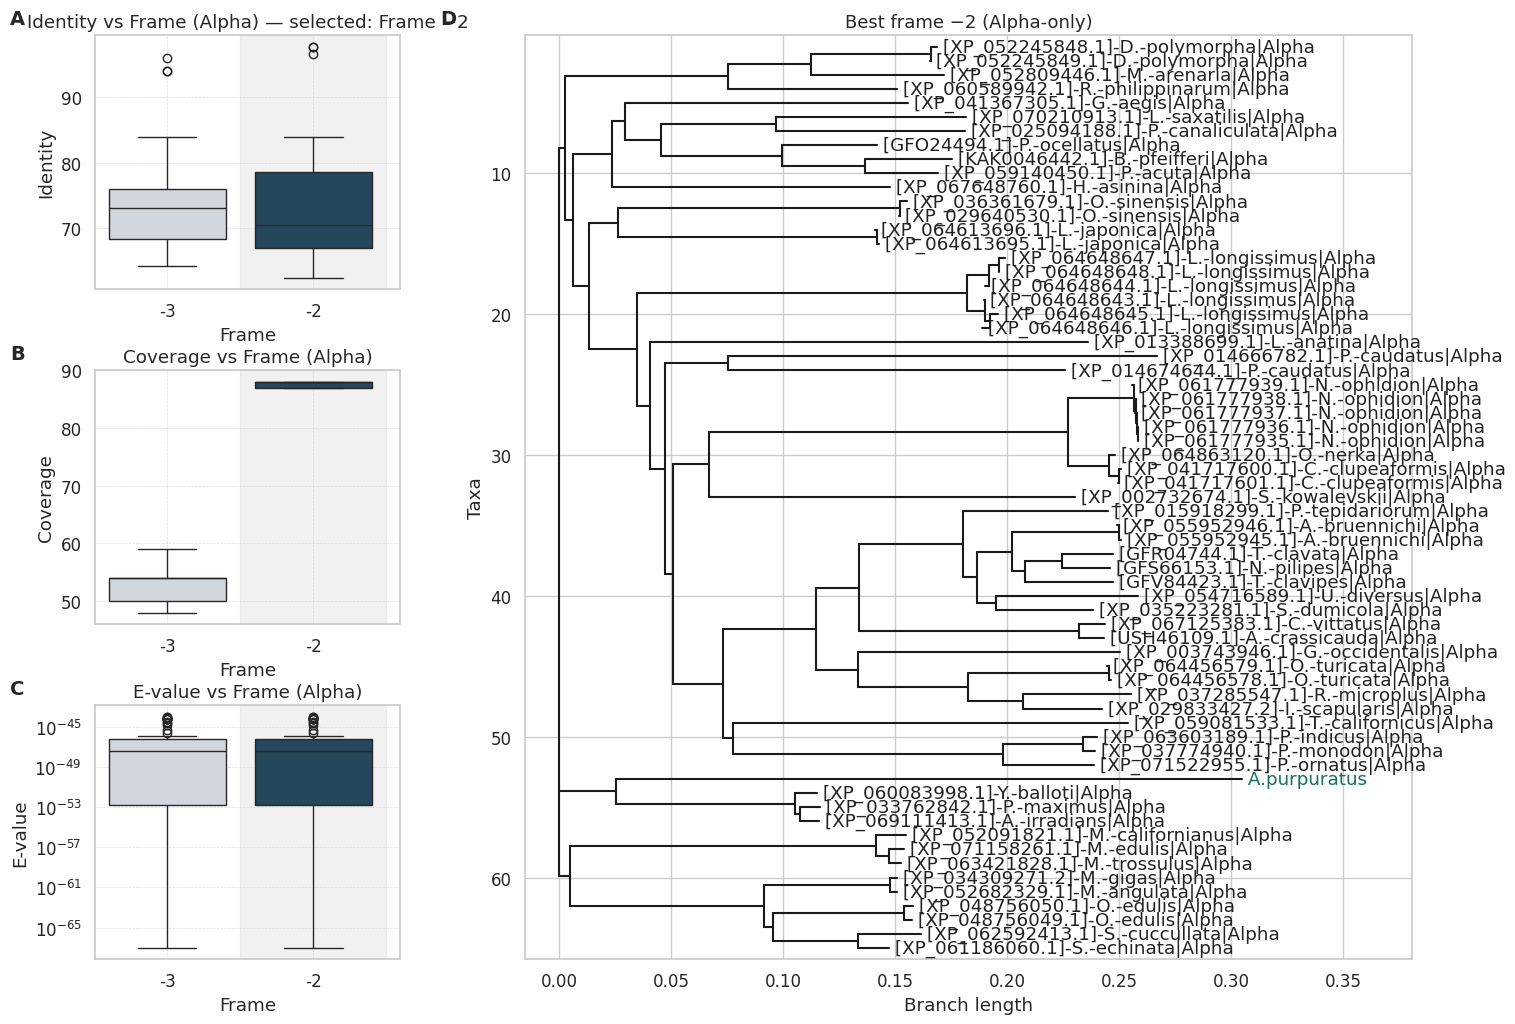

Saved: ../figures_paper/phylo_QC_and_trees.png | ../figures_paper/phylo_QC_and_trees.pdf


In [95]:
ACCENT = "#1b4965"   # color del frame seleccionado
MUTED  = "#d0d7df"   # color del resto

# 1) Asegurar best_frame
try:
    best_frame
except NameError:
    try:
        best_frame, _ = choose_best_frame(df_f2, df_f3, verbose=False)
    except Exception:
        id_med_f2 = np.nanmedian(pd.to_numeric(df_f2["Identity"], errors="coerce")) if len(df_f2) else -np.inf
        id_med_f3 = np.nanmedian(pd.to_numeric(df_f3["Identity"], errors="coerce")) if len(df_f3) else -np.inf
        best_frame = -2 if id_med_f2 >= id_med_f3 else -3

selected_tree = tree_f2 if best_frame == -2 else tree_f3
best_label = "−2" if best_frame == -2 else "−3"

# 2) Normalizar la columna Frame a string (p.ej., "-2", "-3") para evitar mismatches
df_plot = df.copy()
def to_frame_str(x):
    try:
        return str(int(float(x)))  #  -2.0 -> "-2"
    except Exception:
        return str(x).strip()
df_plot["Frame_str"] = df_plot["Frame"].apply(to_frame_str)

# Orden categórico consistente y palette dict con LAS MISMAS claves (strings)
order = sorted(df_plot["Frame_str"].dropna().unique(), key=lambda z: int(z))
palette = {lvl: (ACCENT if int(lvl) == int(best_frame) else MUTED) for lvl in order}
pos_sel = order.index(str(int(best_frame))) if str(int(best_frame)) in order else None

# helper para sombrear categoría seleccionada
def _shade_selected(ax, pos):
    if pos is not None:
        ax.axvspan(pos - 0.5, pos + 0.5, color="k", alpha=0.06, zorder=0)

# 3) Figura
fig = plt.figure(figsize=(17, 12), constrained_layout=False)
gs = GridSpec(nrows=3, ncols=3, figure=fig,
              width_ratios=[1.0, 1.25, 1.25], wspace=0.35, hspace=0.32)

# QC izquierda
axA = fig.add_subplot(gs[0, 0])
axB = fig.add_subplot(gs[1, 0])
axC = fig.add_subplot(gs[2, 0])

# Árbol a la derecha (toda la altura)
axD = fig.add_subplot(gs[:, 1:])

# A: Identity vs Frame
sns.boxplot(data=df_plot, x="Frame_str", y="Identity", ax=axA, order=order, palette=palette)
_shade_selected(axA, pos_sel)
axA.set_xlabel("Frame"); axA.set_title(f"Identity vs Frame (Alpha) — selected: Frame {best_label}")
axA.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# B: Coverage vs Frame
sns.boxplot(data=df_plot, x="Frame_str", y="Coverage", ax=axB, order=order, palette=palette)
_shade_selected(axB, pos_sel)
axB.set_xlabel("Frame"); axB.set_title("Coverage vs Frame (Alpha)")
axB.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# C: E-value vs Frame (log)
sns.boxplot(data=df_plot, x="Frame_str", y="E-value", ax=axC, order=order, palette=palette)
_shade_selected(axC, pos_sel)
axC.set_yscale("log"); axC.set_xlabel("Frame"); axC.set_title("E-value vs Frame (Alpha)")
axC.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# D: Árbol del mejor frame
draw_tree_ax(selected_tree, axD, f"Best frame {best_label} (Alpha-only)")

# Letras de panel (usa tu add_panel_letter existente)
for ax, L in [(axA,"A"), (axB,"B"), (axC,"C"), (axD,"D")]:
    add_panel_letter(fig, ax, L)

fig.savefig(OUT_FIG, dpi=300, bbox_inches="tight")
fig.savefig(OUT_PDF, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", OUT_FIG, "|", OUT_PDF)
